(ch:specstat)=
# First Look at Longslit Data

In this note, 
1. I will show you what the spectroscopic data looks like,
2. Use data from a publication ([Greco+2018 ApJ](https://ui.adsabs.harvard.edu/abs/2018ApJ...866..112G/abstract)) to do some Bayesian analysis.

**Please refer to our [Books](https://github.com/ysBach/SNU_AOclass/tree/master/Books).** In the Bayesian statistics chapter, I detailed the calculations described in this lecture note.

## Realistic Data
The following image shows an example of spectroscopic data. In the middle, there is the spectrum of the target. As you expect, the horizontal axis is the wavelength (λ) direction (λ may increase towards left or right). This direction is called the **dispersion direction** (or dispersion axis). But since the slit has a finite width, much larger than the point source we are observing, there are sky spectra above and below. This vertical direction is called the **spatial direction**.
![](figs/spec_concept.png)

## Example: Greco et al. 2018
In the Greco+2018 paper, they derived the spectra of the two diffuse dwarf galaxies discovered by Subaru HSC-SSP. The follow-up observation was made by Gemini-South's GMOS (optical long-slit spectroscopy). 


![](figs/Greco2018F1.png)

*Figure 1 caption: HSC-SSP gri (Lupton et al. 2004) composite images of LSBG-285 (left column) and LSBG-750 (right column). In each HSC-SSP panel, the red lines show the slit position (Section 3.1).*

![](figs/Greco2018F2.png)

*Figure 2 caption: 2D (top) and 1D (bottom) spectra of LSBG-285 (left) and LSBG-750 (right). Red lines show individual 0.6 kpc extractions, and blue points show the full galaxy extraction. The red 1D spectra have been scaled by a factor of two for visibility. The best-fit spectral-line models (Section 3.2) are indicated by the black lines. The median [N II] λ6583/Hα value and associated 16th and 84th percentile uncertainties, which we derive from the marginalized posterior probability distributions, are indicated near each spectrum in the relevant panels.*

```{admonition} Descriptions of the data 
:class: info, dropdown 

**Scientific Information**
: From the long slit, they can extract the fluxes of [O III] (or [O<sup>2+</sup>]), Hβ, and [NII] (or [N<sup>+</sup>]). From the ratios [O<sup>2+</sup>]/Hβ and [N<sup>+</sup>]/Hα, one can plot the BPT diagram (Fig 4 of the paper). In this work, they calculated Hα flux by assuming Hα/Hβ = 2.81, which is the _Case B_ recombination equilibrium case for 10,000 K at electron number density 10<sup>8</sup> m<sup>-3</sup>. This is possible because they couldn't find any evidence for dust extinction in the galaxy from the SED fitting (from Fig 3 of the paper, A < 0.1 for V-band). From Hα, they used an empirical relationship to get the star formation rate (SFR), although it maybe uncertain to use the relation down to these faint objects. 

**Technical Information**
: For the observation, they used an 831 lines/mm grating with a wide slit width of 2-arcsec. The data underwent 4-pixel binning, which results in 0.3 arcsec/pixel in spatial and 1.5 Å/pixel (~70 km/s at 6563Å) in dispersion direction, covering wavelengths of 4800 to 7200 Å. 

The obtained 2-D spectra (top panel of Figure 2) that are chopped into 0.6 kpc in spatial direction (red dashes), and each strip's spectrum is extracted below (red histograms). The combined spectra with error-bars are shown at the bottom. 
```

Here, we want to examine the "full extraction" data of LSBG-285 at the [O<sup>2+</sup>] wavelength region (left column of Fig. 2 above). I extracted the data manually from [WebPlotDitigizer](https://automeris.io/WebPlotDigitizer/):
![](figs/Greco2018webplotdititizer.png)

In [1]:
from IPython.display import Video
Video("figs/Greco2018webplotdititizer.mp4", width=700)

# Model Selection

Is it really (mathematically and statistically) significant to say there is an emission line there? How can we defend ourselves if someone says, "That's noise, not a signal"? Here, I demonstrate a brute-force Bayesian approach to quantifying this argument.

In [7]:
from pathlib import Path
import pandas as pd
# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr' 
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

def gauss(x, amp, mu, sig):
    return amp * np.exp(-(x - mu)**2/(2*sig**2))

def const_g(x, amp, mu, sig, const):
    return const + gauss(x, amp, mu, sig)


# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix', 
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5, 
    'xtick.top': True, 'ytick.right': True, 
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

In [4]:
DATADIR = Path("../../Tutorial_Data")
data_raw = pd.read_csv(DATADIR/"Greco2018_data.csv", names=["wl", "fl"])
data = dict(wlen=[], flux=[], dflux=[])
for i in range(data_raw.shape[0]//2):
    row1 = data_raw.iloc[2*i]
    row2 = data_raw.iloc[2*i+1]
    wl1, wl2 = row1["wl"], row2["wl"]
    fl1, fl2 = row1["fl"], row2["fl"]
    if abs(wl1 - wl2) > 1:
        print(f"{2*i}- and {2*i+1}-th row have problems?")
    wlen = np.mean([row1["wl"], row2["wl"]])
    flux = min(fl1, fl2)
    dflux = max(fl1, fl2) - flux
    data["wlen"].append(wlen)
    data["flux"].append(flux*1.e-20)  # unit of J/s/m2/Å, not cgs.
    data["dflux"].append(dflux*1.e-20)
data = pd.DataFrame.from_dict(data)

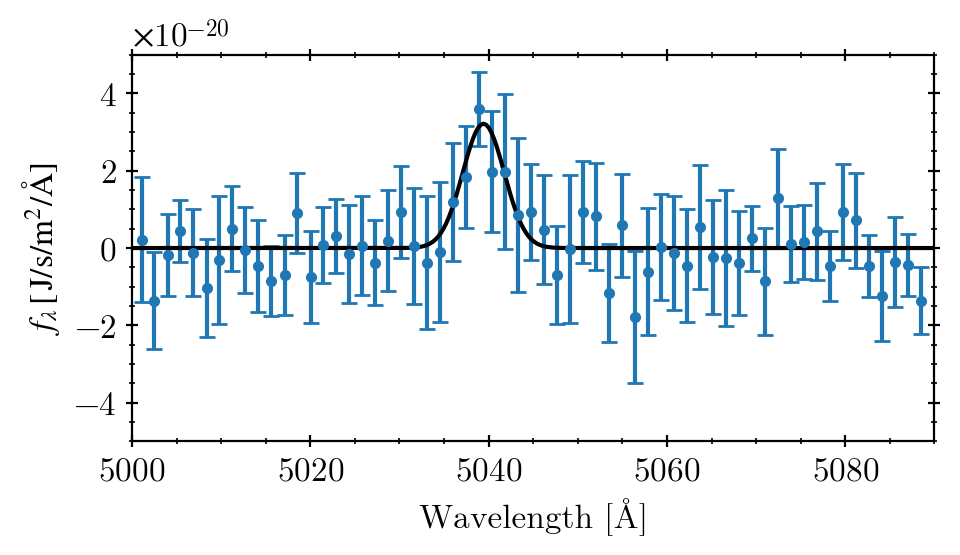

lg(flux) = -15.73 [mW/m2] 
     λ_c = 5039.4 [Å] 
     σ_v = 2.33 [Å]
[3.21328794e-20 5.03942509e+03 2.32657787e+00]


In [29]:
xx = np.linspace(5000, 5090, 300)
wlen = data["wlen"]
flux = data["flux"]
ferr = data["dflux"]
function = gauss
popt, _ = curve_fit(function, wlen, flux, sigma=ferr, 
                    absolute_sigma=True, p0=[1.e-20, 5039, 1])

fig, axs = plt.subplots(1, 1, figsize=(5, 3))

axs.errorbar(wlen, flux, ferr,
             marker='.', capsize=3, ls='')
axs.plot(xx, function(xx, *popt), 'k-')
axs.set(xlim=(5000, 5090), ylim=(-5e-20, 5e-20),
        xlabel="Wavelength [Å]",
        ylabel=r"$f_\lambda \,[\,\mathrm{J/s/m^2/\AA}]$")
axs.grid()
plt.tight_layout()
plt.show()

flux_fit = popt[0] * np.sqrt(2*np.pi*popt[2]**2)
lgf_mW = np.log10(flux_fit) + 3
print("lg(flux) = {:.2f} [mW/m2] \n     λ_c = {:.1f} [Å] \n     σ_v = {:.2f} [Å]"
      .format(lgf_mW, popt[1], popt[2]))
print(popt)

It looks similar to the original one, right? :) 

* **NOTE**: The original paper obtained $\log_{10} F_{\mathrm{O III}} / \mathrm{erg\, cm^{-2}\, s^{-1}} = -15.7 \pm 0.1 $, where $ 1 \mathrm{erg\, cm^{-2}\, s^{-1}} = 1 \mathrm{mW/m^2} $.
* **NOTE**: The original paper argues that they used gaussian with a flat spectrum. When I tried this, however, the best fit constant was $-1.36\times 10^{-21}$, which must be a marginally visible negative shift to the fitted Gaussian, but I cannot find this by zooming in on the paper's plot. Thus, I guess they may have just ignored this flat offset or set a bound that this constant must be positive, so that the best fit value is just 0.
> From the paper: When fitting the [O III] λ5007 line, we assume a flat continuum plus a single Gaussian line profile with standard deviation given by the Hα fit.

Let's calculate the log-likelihoods and related quantities. The log-likelihood is nothing but the natural log of the multiplication of the probability of each data point. If you are interested, search for [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) and [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion). Here, I will test the null and alternative hypotheses.

* H0: no line (flat spectrum),
* H1: one Gaussian emission line.

In [30]:
C_sigma = np.sum(np.log(1/np.sqrt(2*np.pi*ferr**2)))
print(f"C_sigma = {C_sigma:.4f}")


def model_H0(x):
    return 0

def model_H1(x, amp, mu, sig):
    return gauss(x, amp, mu, sig)

def lgl(x, y, sigma, model, *model_args, **model_kwargs):    
#     const = np.sum(np.log(1/np.sqrt(2*np.pi*sigma**2)))
    const = C_sigma
    y_hat = model(x, *model_args, **model_kwargs)
    chisq = np.sum(((y - y_hat)/sigma)**2)
    return const - 0.5*chisq

N = len(flux)
n_0 = 0
n_1 = 3
lgl_0 = lgl(wlen, flux, ferr, model_H0)
lgl_1 = lgl(wlen, flux, ferr, model_H1, *popt)
bic_0 = n_0 * np.log(N) - 2 * lgl_0
bic_1 = n_1 * np.log(N) - 2 * lgl_1
aic_0 = 2 * n_0 - 2 * lgl_0
aic_1 = 2 * n_1 - 2 * lgl_1

print("Log-likelihoods: ", lgl_0, lgl_1)
print(f"Odds = {np.exp(lgl_1 - lgl_0)}")
print()
print(f"BIC = {bic_0}, {bic_1}")
print(f"dBIC = {bic_0 - bic_1}")
print()
print(f"AIC = {aic_0}, {aic_1}")
print(f"dAIC = {aic_0 - aic_1}")

C_sigma = 2739.2343
Log-likelihoods:  2720.810233133312 2730.1358406902464
Odds = 11221.73225326976

BIC = -5441.620466266624, -5447.939059787973
dBIC = 6.318593521348703

AIC = -5441.620466266624, -5454.271681380493
dAIC = 12.651215113868602


Since both dBIC and dAIC are ≫1, it indicates the null hypothesis is well rejected, i.e., we may proceed the calculation based on the assumption of the existence of a Gaussian emission line.

Below is one of the worst ways to code. But to give you a very explicit sense of how the chi-square calculation should be done, I used a nested for loop without using, e.g., ``numba``:

In [31]:
sig = popt[2]  # fixed

arr_amp = np.arange(0.1, 6, 0.1)*1.e-20
arr_flux = arr_amp * np.sqrt(2*np.pi*sig**2)
arr_mu = np.arange(5030, 5050, 0.1)

arr_chi2 = np.zeros((arr_amp.shape[0], arr_mu.shape[0]))
for i, amp in enumerate(arr_amp):
    for j, mu in enumerate(arr_mu):
        resid = flux - gauss(wlen, amp, mu, sig)
        chi2 = np.sum((resid/ferr)**2)
        arr_chi2[i, j] = chi2
        
chi2_min = np.sum(((flux - gauss(wlen, *popt)) / ferr)**2)

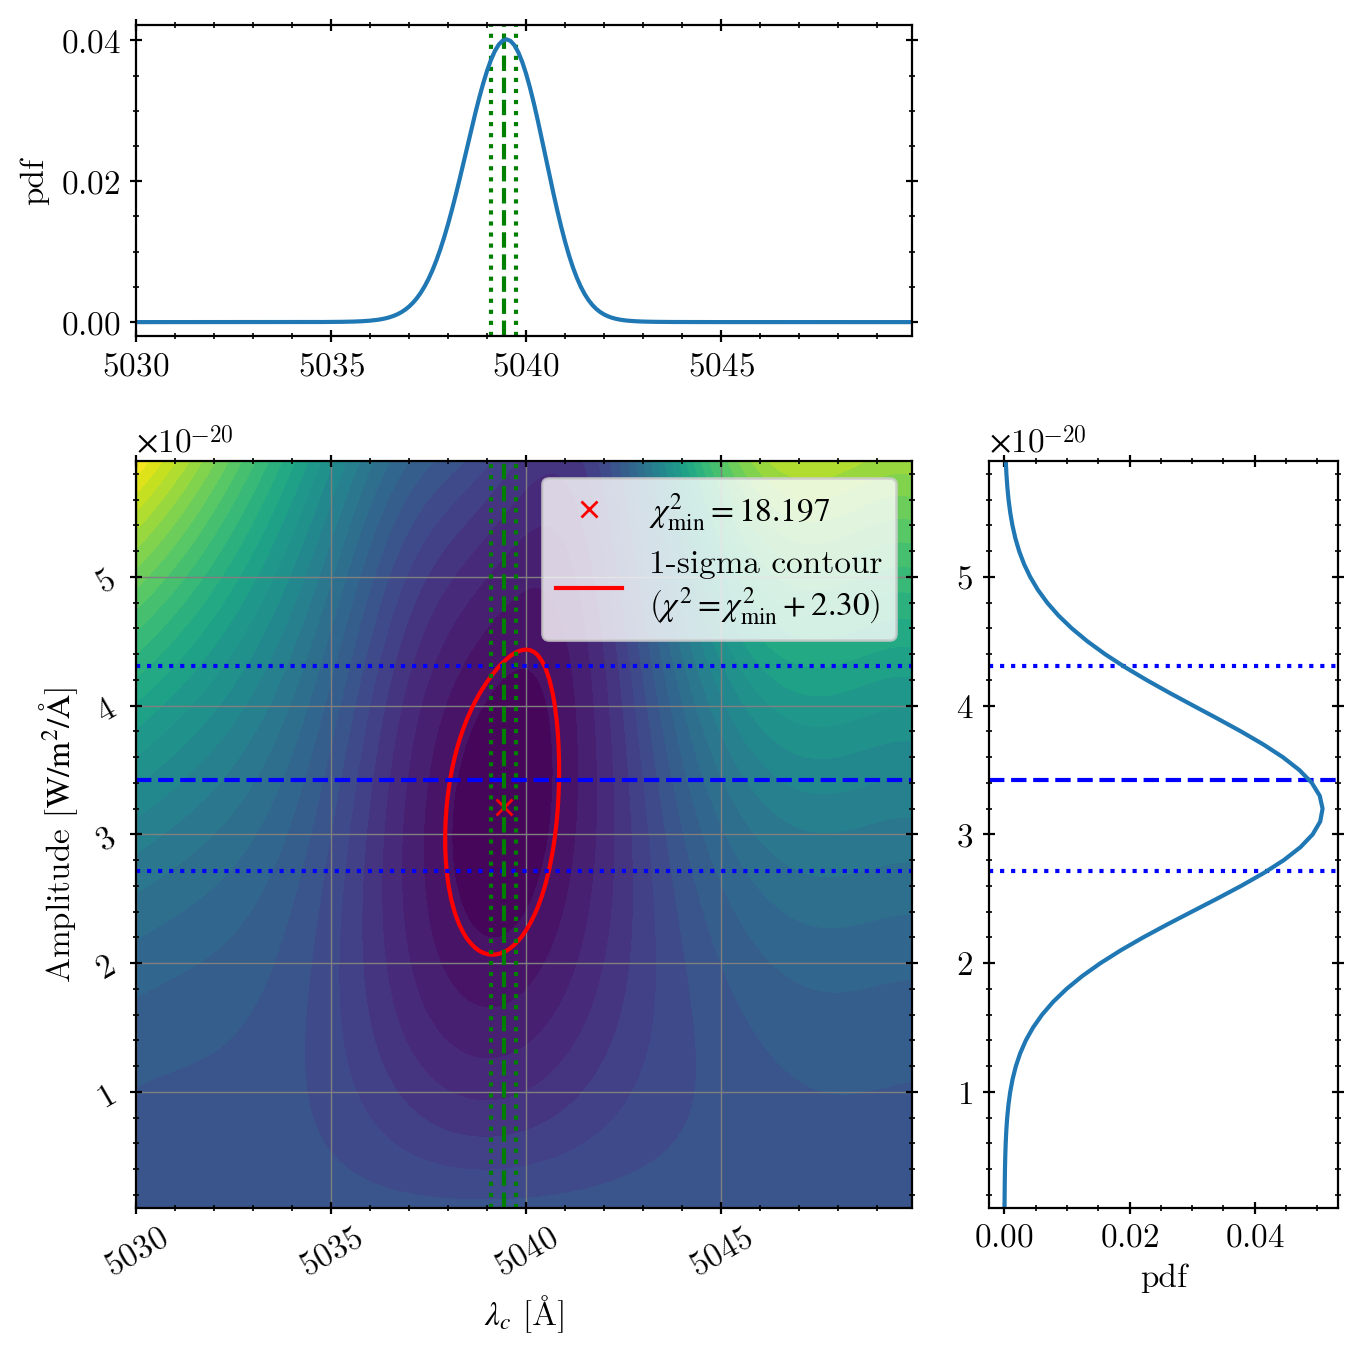

In [32]:
from matplotlib import gridspec
paper = dict(lgfl=-18.7, dlgfl=0.1)
paper["amp"] = 10**paper["lgfl"]/np.sqrt(2*np.pi*sig**2)
paper["amp_hi"] = 10**(paper["lgfl"] + paper["dlgfl"])/np.sqrt(2*np.pi*sig**2)
paper["amp_lo"] = 10**(paper["lgfl"] - paper["dlgfl"])/np.sqrt(2*np.pi*sig**2)
l_OIII = 5008.2  # Å in vacuo
dz = 6.3e-5

fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(3, 3)
ax_c = fig.add_subplot(gs[1:, :2])      # chi2 contour
ax_l = fig.add_subplot(gs[0, :2], sharex=ax_c)  # central wavelength
ax_a = fig.add_subplot(gs[1:, 2], sharey=ax_c)  # amplitude

ax_c.contourf(arr_mu, arr_amp, arr_chi2, levels=30)
ax_c.plot(popt[1], popt[0], 'rx', 
          label=r"$\chi^2_\mathrm{{min}} = {:.3f}$".format(chi2_min))
cs = ax_c.contour(arr_mu, arr_amp, arr_chi2, 
                  levels=[chi2_min + 2.30], colors='r')
ax_c.plot(np.nan, np.nan, 'r-', 
          label="1-sigma contour\n" + r"($\chi^2 = \chi^2_\mathrm{min} + 2.30$)")
ax_c.tick_params(rotation=30)
ax_c.set(xlabel=r"$\lambda_c$ [Å]", ylabel=r"Amplitude [$\mathrm{W/m^2/\AA}$]")

for ax in [ax_c, ax_a]:
    ax.axhline(paper["amp"], color='b', ls='--')
    ax.axhline(paper["amp_hi"], color='b', ls=':')
    ax.axhline(paper["amp_lo"], color='b', ls=':')

for ax in [ax_c, ax_l]:
    ax.axvline(popt[1], color='g', ls='--')
    ax.axvline(popt[1] + l_OIII*dz, color='g', ls=':')
    ax.axvline(popt[1] - l_OIII*dz, color='g', ls=':')
    
prob = np.exp(-arr_chi2/2)
norm = np.sum(prob)
prob_mu = np.sum((prob/norm), axis=0)
prob_amp = np.sum((prob/norm), axis=1)

ax_l.plot(arr_mu, prob_mu)
ax_a.plot(prob_amp, arr_amp)
ax_l.set(ylabel="pdf")
ax_a.set(xlabel="pdf")

ax_l.grid()
ax_a.grid()
ax_c.legend()
plt.tight_layout()
plt.show()

The green vertical lines:
* dashed = our best fit central wavelength
* dotted = the uncertainty range from the paper's redshift uncertainty measured from Hα line (1742 +- 19 km/s)
* Because their uncertainty is from Hα, which has a signal much better than O<sup>2+</sup>, the error-bar is much smaller than ours.

The blue horizontal lines:
* dashed = paper's flux ($10^{-15.7}$ mW/m2) converted to amplitude
* dotted = paper's uncertainty around the paper's value.
* The difference between our fit and the paper's value is only 0.03 dex (maybe the authors obtained the identical value but just dropped the significance numbers).
* Error bars seem slightly understimated, but in reality, if we use an error bar of 0.14 dex in the log scale, it's similar to ours. Maybe the authors just did not care about such detailed numbers, which is understandable.